# AiiDA by example: Computing a band structure


:::{admonition} Learning Objectives
:class: learning-objectives

In this section we will present a complete example of an AiiDA workflow, which defines the sequence of calculations needed to compute the band structure of silicon.

How to setup the input data and the details of the workflow execution will be discussed in subsequent sections.
Here we simply give an initial overview of what it means to run an AiiDA workflow.

:::

## Interacting with AiiDA

AiiDA can be controlled in two ways:

1. Using the `verdi` command line interface (CLI), or `%verdi` magic in Jupyter notebooks.
2. Using the `aiida` Python API

For each project in AiiDA, we set up a *profile*, which defines the connection to the data storage, and other settings.

In [1]:
from local_module import load_temp_profile

data = load_temp_profile()
data

AiiDALoaded(profile=Profile<uuid='d5f25ad6ebc94261954ebe6ce02c3d70' name='temp_profile'>, computer=<Computer: local_direct (localhost), pk: 1>, code=<Code: Remote code 'pw.x' on local_direct, pk: 1, uuid: 083eec41-51d1-4ca0-a9e6-db771b7eb58a>, pseudos=SsspFamily<1>, structure=<StructureData: uuid: bb18c314-6f5a-486a-b5fd-ad055c8babdb (pk: 87)>)

In [2]:
%verdi status --no-rmq

 ✔ version:     AiiDA v2.0.4
 ✔ config:      /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/local_module/_aiida_path/.aiida
 ✔ profile:     temp_profile
 ✔ storage:     SqliteTemp storage [open], sandbox: /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/local_module/_aiida_path/.aiida/repository/temp_profile
 ⏺ daemon:      The daemon is not running


Within this profile, we have stored the initial input components for our workflow, including the pseudo-potentials, and the silicon structure:

In [5]:
%verdi storage info --detailed

entities:
  Users:
    count: 1
    emails:
    - user@email.com
  Computers:
    count: 1
    labels:
    - local_direct
  Nodes:
    count: 88
    node_types:
    - data.core.code.Code.
    - data.core.structure.StructureData.
    - data.pseudo.upf.UpfData.
    process_types: []
  Groups:
    count: 1
    type_strings:
    - pseudo.family.sssp
  Comments:
    count: 0
  Logs:
    count: 0
  Links:
    count: 0



We have also set up the compute resource that we will use to run the calculations, and the code (`pw.x`) installed on that computer, which we will use to perform the electronic structure calculations.

Here, we will use our "local" machine to run the computations, but AiiDA can also be used to submit calculations to remote supercomputer schedulers, transporting data between the local machine and the remote computer.

In [6]:
%verdi computer show local_direct

---------------------------  ---------------------------------------------------------------------------
Label                        local_direct
PK                           1
UUID                         572fa678-7b88-4669-a236-16e06cfc0e84
Description                  local computer with direct scheduler
Hostname                     localhost
Transport type               core.local
Scheduler type               core.direct
Work directory               /workspaces/aiida-qe-demo/tutorial/local_module/_aiida_workdir/temp_profile
Shebang                      #!/bin/bash
Mpirun command               mpirun -np {tot_num_mpiprocs}
Default #procs/machine       2
Default memory (kB)/machine
Prepend text
Append text
---------------------------  ---------------------------------------------------------------------------


In [7]:
%verdi code show pw.x@local_direct

--------------------  --------------------------------------
PK                    1
UUID                  56510da2-9f5a-4756-b5b9-2d079a86dbcf
Label                 pw.x
Description           pw.x code on local computer
Default plugin        quantumespresso.pw
Type                  remote
Remote machine        local_direct
Remote absolute path  /opt/conda/envs/aiida-qe-demo/bin/pw.x
Prepend text          export OMP_NUM_THREADS=1
Append text
--------------------  --------------------------------------


## Utilising a pre-defined workflow

AiiDA plugins can declare workflow plugins, for use within AiiDA.
These are workflows that are pre-defined, and can be used as-is, or as a starting point for your own workflows.

Here we utilise the `quantumespresso.pw.bands` workflow defined by the [`aiida-quantumespresso`](https://aiida-quantumespresso.readthedocs.io) plugin.

In [8]:
%verdi plugin list aiida.workflows

Registered entry points for aiida.workflows:
* core.arithmetic.add_multiply
* core.arithmetic.multiply_add
* quantumespresso.matdyn.base
* quantumespresso.pdos
* quantumespresso.ph.base
* quantumespresso.pw.bands
* quantumespresso.pw.base
* quantumespresso.pw.relax
* quantumespresso.q2r.base

Report: Pass the entry point as an argument to display detailed information


In [9]:
%verdi plugin list aiida.workflows quantumespresso.pw.bands

Description:

    Workchain to compute a band structure for a given structure using Quantum ESPRESSO pw.x.
    
    The logic for the computation of various parameters for the BANDS step is as follows:
    
    Number of bands:
    One can specify the number of bands to be used in the BANDS step either directly through the input parameters
    `bands.pw.parameters.SYSTEM.nbnd` or through `nbands_factor`. Note that specifying both is not allowed. When
    neither is specified nothing will be set by the work chain and the default of Quantum ESPRESSO will end up being
    used. If the `nbands_factor` is specified the maximum value of the following values will be used:
    
    * `nbnd` of the preceding SCF calculation
    * 0.5 * nspin * nelectrons * nbands_factor
    * 0.5 * nspin * nelectrons + 4 * nspin
    
    Kpoints:
    There are three options; specify either an existing `KpointsData` through `bands_kpoints`, or specify the
    `bands_kpoint_distance`, or specify neither. For the 

The `quantumespresso.pw.bands` workflow provides a helpful method for setting up the default inputs for a given "protocol", as to how fast/precise the calculation should be.
This provides a "builder" object, which stores all the inputs for the workflow.

In [10]:
from aiida_quantumespresso.workflows.pw.bands import PwBandsWorkChain

builder = PwBandsWorkChain.get_builder_from_protocol(
    code=data.code, 
    structure=data.structure,
    protocol="fast",
)
builder

Process class: PwBandsWorkChain
Inputs:
bands:
  metadata: {}
  pw:
    code: pw.x code on local computer
    metadata:
      options:
        max_wallclock_seconds: 43200
        resources:
          num_machines: 1
        stash: {}
        withmpi: true
    parameters:
      CONTROL:
        calculation: scf
        etot_conv_thr: 0.0002
        forc_conv_thr: 0.001
        tprnfor: true
        tstress: true
      ELECTRONS:
        conv_thr: 8.0e-10
        electron_maxstep: 80
        mixing_beta: 0.4
      SYSTEM:
        degauss: 0.01
        ecutrho: 240.0
        ecutwfc: 30.0
        nosym: false
        occupations: smearing
        smearing: cold
    pseudos:
      Si: ''
bands_kpoints_distance: 0.1
clean_workdir: true
metadata: {}
nbands_factor: 3.0
relax:
  base:
    kpoints_distance: 0.5
    kpoints_force_parity: false
    metadata: {}
    pw:
      code: pw.x code on local computer
      metadata:
        options:
          max_wallclock_seconds: 43200
          resour

## Running the workflow

Workflows can be run in the interpreter using the `run` method, in a blocking manner, which we shall do here.

In [11]:
from aiida import engine

result = engine.run_get_node(builder)
result

Report: [105|PwBandsWorkChain|run_relax]: launching PwRelaxWorkChain<107>
Report: [107|PwRelaxWorkChain|run_relax]: launching PwBaseWorkChain<110>
Report: [110|PwBaseWorkChain|run_process]: launching PwCalculation<115> iteration #1
Report: [110|PwBaseWorkChain|results]: work chain completed after 1 iterations
Report: [110|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
Report: [107|PwRelaxWorkChain|inspect_relax]: after iteration 1 cell volume of relaxed structure is 40.97320472105803
Report: [107|PwRelaxWorkChain|run_relax]: launching PwBaseWorkChain<124>
Report: [124|PwBaseWorkChain|run_process]: launching PwCalculation<129> iteration #1
Report: [124|PwBaseWorkChain|results]: work chain completed after 1 iterations
Report: [124|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
Report: [107|PwRelaxWorkChain|inspect_relax]: after iteration 2 cell volume of relaxed structure is 41.15161590467152
Report: [107|PwRelaxWorkChain|inspect_relax]: relative c

ResultAndNode(result={'primitive_structure': <StructureData: uuid: 39065e88-7f76-406b-9497-6301a0565821 (pk: 139)>, 'seekpath_parameters': <Dict: uuid: d189a028-0dbb-401f-8cc5-57b37bf9a17f (pk: 137)>, 'scf_parameters': <Dict: uuid: 39c3b7b5-41b8-44e3-9529-e18ac7661a05 (pk: 153)>, 'band_parameters': <Dict: uuid: 43f6b860-6f9b-4c92-8996-91dfe2b998f3 (pk: 164)>, 'band_structure': <BandsData: uuid: ab7a925a-055c-4cbb-a09c-a1d10d8889e4 (pk: 162)>}, node=<WorkChainNode: uuid: 7e0c3c71-cf6c-49a4-9509-79faf2fd432a (pk: 105) (aiida.workflows:quantumespresso.pw.bands)>)

Typically however, long running workflows are executed by using the `submit` method.
This will store the initial state of the workflow in the profile storage, and notify the AiiDA daemon to run the workflow in the background.

The AiiDA daemon can be launched using the `verdi daemon start n` command, with `n` being the number of worker processes to launch.
Each worker can asynchronously handle 1000s of individual calculations, allowing for a high-throughput of workflow submissions.

![daemon illustration](_static/aiida/rabbitmq-sysml.svg){height=200px align=center}

Each workflow and node stored in the AiiDA profile is assigned a unique identifier (a.k.a Primary Key), which can be used to reference them.
The execution of the workflows can be monitored using the `verdi process list` command, which will show the status of all running processes in the profile (or also finished ones with `-a`).

In [12]:
%verdi process list -a

  PK  Created    Process label                 Process State    Process status
----  ---------  ----------------------------  ---------------  ----------------
 105  2m ago     PwBandsWorkChain              ⏹ Finished [0]
 107  1m ago     PwRelaxWorkChain              ⏹ Finished [0]
 110  1m ago     PwBaseWorkChain               ⏹ Finished [0]
 111  1m ago     create_kpoints_from_distance  ⏹ Finished [0]
 115  1m ago     PwCalculation                 ⏹ Finished [0]
 124  1m ago     PwBaseWorkChain               ⏹ Finished [0]
 125  1m ago     create_kpoints_from_distance  ⏹ Finished [0]
 129  1m ago     PwCalculation                 ⏹ Finished [0]
 136  41s ago    seekpath_structure_analysis   ⏹ Finished [0]
 143  40s ago    PwBaseWorkChain               ⏹ Finished [0]
 144  40s ago    create_kpoints_from_distance  ⏹ Finished [0]
 148  40s ago    PwCalculation                 ⏹ Finished [0]
 156  31s ago    PwBaseWorkChain               ⏹ Finished [0]
 159  30s ago    PwCalculation    

We can also monitor the progress of individual workflows using the `verdi process status` command, which will show the status of the individual steps of the workflow.

In [13]:
%verdi process status {result.node.pk}

PwBandsWorkChain<105> Finished [0] [7:results]
    ├── PwRelaxWorkChain<107> Finished [0] [3:results]
    │   ├── PwBaseWorkChain<110> Finished [0] [4:results]
    │   │   ├── create_kpoints_from_distance<111> Finished [0]
    │   │   └── PwCalculation<115> Finished [0]
    │   └── PwBaseWorkChain<124> Finished [0] [4:results]
    │       ├── create_kpoints_from_distance<125> Finished [0]
    │       └── PwCalculation<129> Finished [0]
    ├── seekpath_structure_analysis<136> Finished [0]
    ├── PwBaseWorkChain<143> Finished [0] [4:results]
    │   ├── create_kpoints_from_distance<144> Finished [0]
    │   └── PwCalculation<148> Finished [0]
    └── PwBaseWorkChain<156> Finished [0] [4:results]
        └── PwCalculation<159> Finished [0]


This work-chain demonstrates how we can build up a complex workflow from a series of individual calculations.
In this case, the workflow is made up of the following steps:

1. The `PwRelaxWorkChain` will run multiple Quantum ESPRESSO `vc-relax` calculations, to make sure that there are no Pulay stresses present in the material and that the requested k-points density is respected in case there is a significant volume change in the material.
2. Once the geometry has been optimized, SeeK-path will be used to primitivize and standardize the structure, as well as find the standard path along which to calculate the band structure.
3. A static calculation (`scf`) is run to calculate the charge density for the structure obtained from SeeK-path.
4. Finally, an NSCF is run to calculate the band structure along the path determined by Seek-path.

We shall also discuss in subsequent sections, how the `PwBaseWorkChain` can identify and recover from known failure modes, such as reaching the wall-time limit of the scheduler, or convergence failures.

## Inspecting the results

Once we the workflow has finished, we can inspect the results using the `verdi process show` command, which will show the results of the workflow, and its "attached" outputs.

In [14]:
%verdi process show {result.node.pk}

Property     Value
-----------  ------------------------------------
type         PwBandsWorkChain
state        Finished [0]
pk           105
uuid         7e0c3c71-cf6c-49a4-9509-79faf2fd432a
label
description
ctime        2022-10-03 01:02:13.765261+00:00
mtime        2022-10-03 01:04:13.769093+00:00
computer     [1] local_direct

Inputs                               PK    Type
-----------------------------------  ----  -------------
bands
    pw
        pseudos
            Si                       8     UpfData
        code                         1     Code
        parameters                   100   Dict
    max_iterations                   101   Int
relax
    base
        pw
            pseudos
                Si                   8     UpfData
            code                     1     Code
            parameters               89    Dict
        kpoints_distance             90    Float
        kpoints_force_parity         91    Bool
        max_iterations               92    Int
  

### The provenance graph

As well as storing the inputs and outputs of the workflow, and its composite calculations, AiiDA also stores the links between them, which can be used to reconstruct the provenance graph of the workflow.

This can be visualised using the `verdi node graph generate` command, or using the `Graph` Python API.

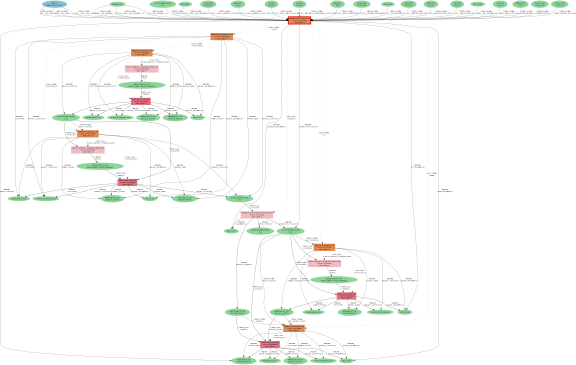

In [15]:
from aiida.tools.visualization import Graph

graph = Graph(graph_attr={"rankdir": "TB", "size": "8!,8!"})
graph.recurse_ancestors(result.node, annotate_links="both")
graph.recurse_descendants(result.node, annotate_links="both")
graph.graphviz

### The output structure

AiiDA's `StructureData` class provides integration with both [ASE](https://wiki.fysik.dtu.dk/ase/), and [Pymatgen](https://pymatgen.org/), which can be used to inspect and visualise the structure.

In [16]:
pym_structure = result.node.outputs.primitive_structure.get_pymatgen()
pym_structure

Structure Summary
Lattice
    abc : 3.875258079537184 3.875258079537184 3.875258079537184
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 41.151615904669846
      A : 0.0 2.7402212668887 2.7402212668887
      B : 2.7402212668887 0.0 2.7402212668887
      C : 2.7402212668887 2.7402212668887 0.0
PeriodicSite: Si (2.7402, 2.7402, 0.0000) [0.0000, 0.0000, 1.0000]
PeriodicSite: Si (4.1103, 1.3701, 4.1103) [0.2500, 1.2500, 0.2500]

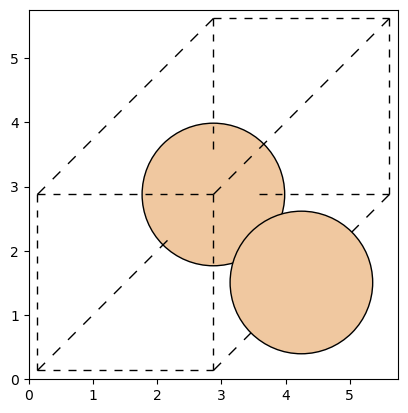

In [17]:
from ase.visualize.plot import plot_atoms

ase_atoms = result.node.outputs.primitive_structure.get_ase()
ax = plot_atoms(ase_atoms)

In [18]:
from ase.visualize.ngl import NGLDisplay

NGLDisplay(ase_atoms).gui

### The output band structure

Finally, we get to our desired result, the band structure of silicon computed using Quantum ESPRESSO 🎉

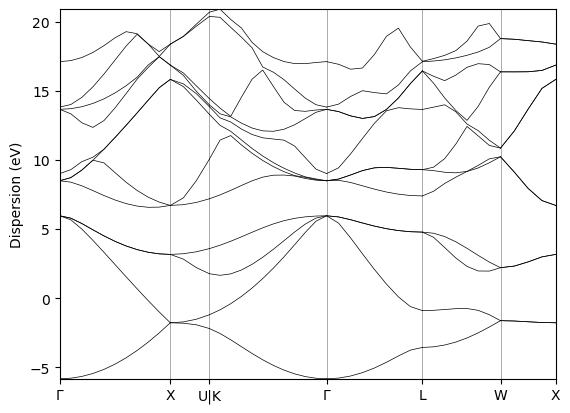

In [19]:
from local_module.bandstructure import plot_bandstructure

bands = result.node.outputs.band_structure
fig, ax = plot_bandstructure(bands)